In [65]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import copy
import time
import matplotlib.dates as md
from matplotlib.ticker import FormatStrFormatter

In [32]:
class Curve:
    def __init__(self, X_T, λ_T, τ=1):
        self.a = X_T
        self.b = λ_T
        self.τ = τ
    
    def __repr__(self):
        return f'{self.a}log(μ)-{self.b:.2f}(μ-1) beginning at {self.τ}.'
    
    def evaluate(self, μ):
        return np.maximum(self.a*np.log(μ) - self.b*(μ-1), 0)
    
    def update(self, X_T, λ_T):
        self.a += X_T
        self.b += λ_T
    
    def __add__(self, other_curve):
        return Curve(self.a+other_curve.a, self.b+other_curve.b, self.τ)
    
    def xmax(self):
        if self.a==0 and self.b==0:
            return 1
        else:
            return self.a/self.b
    
    def ymax(self):
        return self.evaluate(self.xmax())
    
    def slope(self):
        return self.a + self.b
    
    def dominates(self, other_curve):
        return (self.slope()>other_curve.slope())and(self.xmax()>other_curve.xmax())

def focus_step_fast_poisson(curve_difference_list, final_curve, max_list, T, X_T, λ_T, threshold=12.5, min_parameter=1):
    #min_parameter = log(μ_min)/(1- μ_min), avoids having to calculate logarithms

    maxima_required = True
    threshold_met = False

    #start by performing an update:
    if X_T*final_curve.b > λ_T*np.maximum(final_curve.a, min_parameter*final_curve.b):
        #add another curve on
        curve_difference_list.append(copy.copy(final_curve))
        max_list.append(max_list[-1] + final_curve.ymax()) #requires evaluating a logarithm
        final_curve=Curve(X_T, λ_T, τ=T)
    else:
        #just update the final curve
        final_curve.update(X_T, λ_T)

        #check if curves prune each other out
        while curve_difference_list: #nonempty
            if final_curve.a*curve_difference_list[-1].b <= final_curve.b*curve_difference_list[-1].a:
                final_curve = curve_difference_list.pop()+final_curve
                max_list.pop()
            else:
                break

        if final_curve.a<=min_parameter*final_curve.b:
            final_curve=Curve(0, 0, τ=T+1)
    
    #check maximum
    i = 1
    curve_being_checked = final_curve
    
    if X_T <= λ_T*min_parameter:
        maxima_required = False
    while maxima_required:
        
        curve_max = curve_being_checked.ymax() #requires evaluating a logarithm

        if curve_max+max_list[-i] < threshold:
            #no curve maxima meets the threshold
            maxima_required = False

        elif curve_max >= threshold:
            threshold_met=True
            maxima_required=False

        else: #iterate leftwards through curve list
            curve_being_checked = curve_difference_list[-i]+curve_being_checked
            i += 1

    return curve_difference_list, final_curve, max_list, threshold_met    

        
def interpret(curve_difference_list, final_curve):
    #Takes the internals of the fast FOCuS algorithm and re-interprets them in the same format as the internals of the basic FOCuS algorithm
    global_max=final_curve.ymax()
    τ_anomaly=final_curve.τ
    curve_list=[final_curve]
    curve_being_checked = final_curve
        
    for i in range(1, len(curve_difference_list)+1):
        curve_being_checked = curve_difference_list[-i]+curve_being_checked
        
        curve_list.append(copy.copy(curve_being_checked))
        
        if curve_being_checked.ymax() > global_max:
            global_max = curve_being_checked.ymax()
            τ_anomaly = curve_being_checked.τ
    curve_list.reverse()
    
    return curve_list, global_max, τ_anomaly

def plot_curves(curve_list, threshold=25):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("FOCuS Step")
    
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$S_{t}(\mu)$", rotation=0)
    
    ax.set_ylim(-1, threshold+1)
    ax.set_xlim(-0.2, 5.2)
    
    
    ax.axhline(threshold, color='C1')

    mu = np.linspace(0.2, 10, 100) #the x-axis for the plot
    
    for c in curve_list:
        ax.plot(mu, c.evaluate(mu), label=f'$\\tau={c.τ}$')
    
    ax.axhline(0, color='C0')

    if curve_list:
        ax.legend(loc='upper left')
    return fig

def focus_fast_poisson(X, λ, μ_min=1, threshold=np.inf, plot=False, record_signif=False):
    
    if μ_min==1:
        min_parameter=1
    else:
        min_parameter = (μ_min-1)/np.log(μ_min)
    curve_difference_list=[]
    max_list=[0]
    final_curve=Curve(0, 0)
    signif = []
    
    if np.ndim(λ)==0:#scalar
        λ = np.full(X.shape, λ)
    
    for T in range(len(X)):
        curve_difference_list, final_curve, max_list, threshold_met  = focus_step_fast_poisson(curve_difference_list,
                                                                                       final_curve,
                                                                                       max_list, T,
                                                                                       X[T], λ[T],
                                                                                       threshold,
                                                                                       min_parameter)
        
        if record_signif:
            curve_list, global_max, τ_anomaly = interpret(curve_difference_list, final_curve)
            signif.append(global_max)
        
        
        if plot:
            clear_output(wait=True)
            curve_list, global_max, τ_anomaly = interpret(curve_difference_list, final_curve)
            plot_curves(curve_list, threshold=threshold)
            plt.hlines(upper_bounds[T], xmin=1, xmax=4, color="black")
            plt.show()
            #print(curve_list)
        
        #print(max_list)
        if threshold_met:
            curve_list, significance, changepoint = interpret(curve_difference_list, final_curve)
            return significance, changepoint, T, signif
    return 0, None, len(X)+1, signif

In [23]:
data = pd.read_csv("fermi_background.csv", index_col=0, parse_dates=True)
signal = data['count'].fillna(method="backfill").loc['2017-09-13 12:30':'2017-09-13 13:30'].resample("50ms").sum()
tensec = signal.resample("10s").sum()/200
moving_average = signal.rolling("3min", center=True).mean()

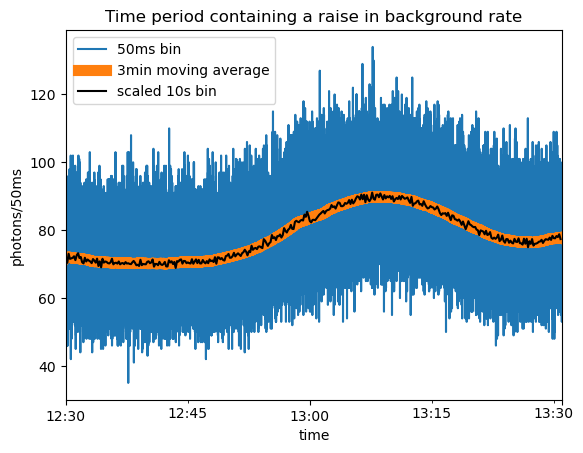

In [73]:
signal.plot(label="50ms bin")
moving_average.plot(color="C1", linewidth=8, label="3min moving average")
tensec.plot(color="black", label="scaled 10s bin")

plt.title("Time period containing a raise in background rate")
plt.xlabel("time")
plt.ylabel("photons/50ms")
plt.legend()
plt.savefig("background_rate_highres", dpi=200)

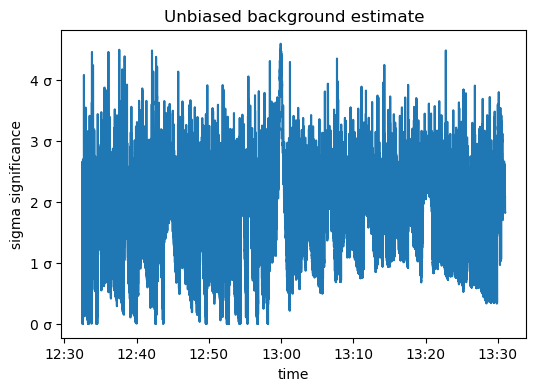

In [70]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal['2017-09-13 12:32:30':], λ=moving_average['2017-09-13 12:32:30':], μ_min=1, threshold=np.inf, plot=False, record_signif=True)
sigma_level = np.sqrt(2*pd.Series(data=significance_array, index=signal['2017-09-13 12:32:30':].index))
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(sigma_level)
plt.title("Unbiased background estimate")
plt.xlabel("time")
plt.ylabel("sigma significance")
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f σ'))

plt.savefig('unbiased_estimation.png', dpi = 200)
plt.show()

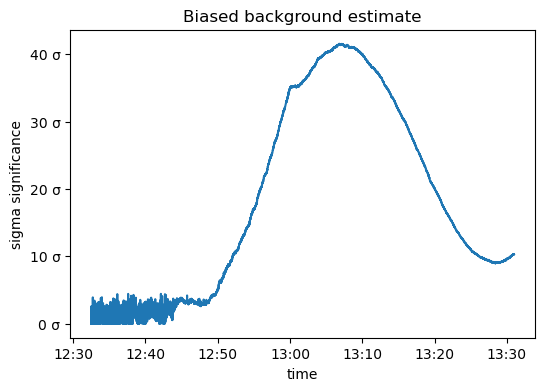

In [71]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal['2017-09-13 12:32:30':], λ=moving_average[:'2017-09-13 13:28:30'], μ_min=1, threshold=np.inf, plot=False, record_signif=True)
sigma_level = np.sqrt(2*pd.Series(data=significance_array, index=signal['2017-09-13 12:32:30':].index))
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(sigma_level)
plt.title("Biased background estimate")
plt.xlabel("time")
plt.ylabel("sigma significance")
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f σ'))

plt.savefig('biased_estimation.png', dpi = 200)
plt.show()

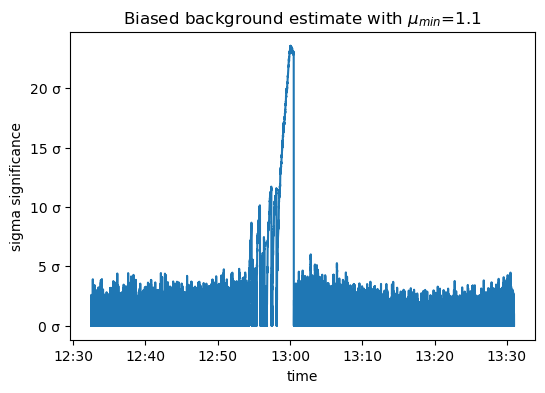

In [72]:
significance, changepoint, stopping_time, significance_array = focus_fast_poisson(X=signal['2017-09-13 12:32:30':], λ=moving_average[:'2017-09-13 13:28:30'], μ_min=1.1, threshold=np.inf, plot=False, record_signif=True)
sigma_level = np.sqrt(2*pd.Series(data=significance_array, index=signal['2017-09-13 12:32:30':].index))
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(sigma_level)
plt.title("Biased background estimate with $\mu_{min}$=1.1")
plt.xlabel("time")
plt.ylabel("sigma significance")
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0f σ'))

plt.savefig('biased_estimation_mumin.png', dpi = 200)
plt.show()